# AI Explainability Made Easy: How Late Interaction Makes Jina-ColBERT Transparent

This notebook accompanies the Jina AI blogpost [AI Explainability Made Easy: How Late Interaction Makes Jina-ColBERT Transparent](https://jina.ai/news/title-of-blogpost). It should run in notebooks serving Python 3.10 or later, or on Google Colab.

## Reranking Models

This section of the notebook contains basic code for accessing the Jina-ColBERT English reranker model (`jina-colbert-v1-en`).

You will be prompted for an API key. You can get one from the [Jina Reranker web page](https://jina.ai/reranker/#apiform).

In [1]:
import getpass

print("Paste your Jina Reranker API key here: ")
jina_api_key = getpass.getpass()

### Required Libraries

Now, install or update the `requests` package.

In [ ]:
!pip install requests -U

### Making Requests to the Jina Reranker API

The code below is basic boilerplate Python code for accessing the Jina Reranker API and processing texts.

In [ ]:
import requests

url = "https://api.jina.ai/v1/rerank"

headers = {
    "Content-Type": "application/json",
    "Authorization": f"Bearer {jina_api_key}"
}
data = {
    "model": "jina-colbert-v1-en",
    "query": "Elephants eat 150 kg of food per day.",
    "documents": [
        "Elephants eat 150 kg of food per day.",
        "Every day, the average elephant consumes roughly 150 kg of food.",
        "The rain in Spain falls mainly on the plain.",
    ],
    "top_n": 3
}

response = requests.post(url, headers=headers, json=data)
for item in response.json()['results']:
    print(f"{item['relevance_score']} : {item['document']['text']}")

## Explaining Rankings with Heat Maps

This section will use the Jina Reranker to create heat maps of token-level interactions between query and target documents, so you can visualize how it scores document pairs.

### Required Libraries

Run the following to install the necessary prerequisites:

In [ ]:
!pip install matplotlib seaborn torch Pillow

### Download utilities

This file contains code for accessing the token-level of the Jina Reranker API and using `matplotlib` to generate heat maps. If you need to, you can [download it directly from GitHub](https://raw.githubusercontent.com/jina-ai/workshops/docs-heatmaps/notebooks/heatmaps/jina_colbert_heatmaps.py).

In [ ]:
!wget https://raw.githubusercontent.com/jina-ai/workshops/docs-heatmaps/notebooks/heatmaps/jina_colbert_heatmaps.py

### Create a Function to Make Heat Maps

With all this in place, we just need one function that takes two texts as arguments and returns a figure:

In [6]:
from jina_colbert_heatmaps import JinaColbertHeatmapMaker

def create_heatmap(query, document, figsize=None):
    heat_map_maker = JinaColbertHeatmapMaker(jina_api_key=jina_api_key)
    # get token embeddings for the query
    query_emb = heat_map_maker.embed(query, is_query=True)
    # get token embeddings for the target document
    document_emb = heat_map_maker.embed(document, is_query=False)
    return heat_map_maker.compute_heatmap(document_emb[0], query_emb[0], figsize)

### Making Heat Maps

Let's make a heat map showing the interaction between the two texts.

First, we'll use two identical texts: "Elephants eat 150 kg of food per day."

This code may take several minutes to run the first time since it has to download a lot of data. If you are not using a CUDA-enabled runtime, it may take a minute to run even after the first time.

This *should* display the image automatically. If not, change the code to:

```
img = create_heatmap(....
display(img)
```


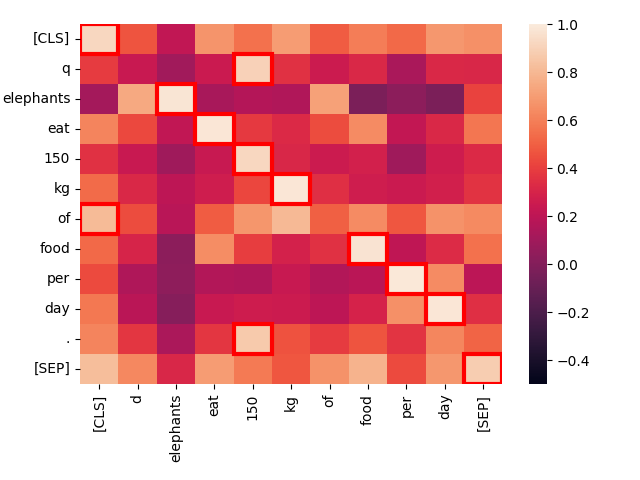

In [7]:
create_heatmap("Elephants eat 150 kg of food per day.", "Elephants eat 150 kg of food per day.")

Next, compare these two texts:
* "Elephants eat 150 kg of food per day."
* "Cats eat 50 g of food per day."

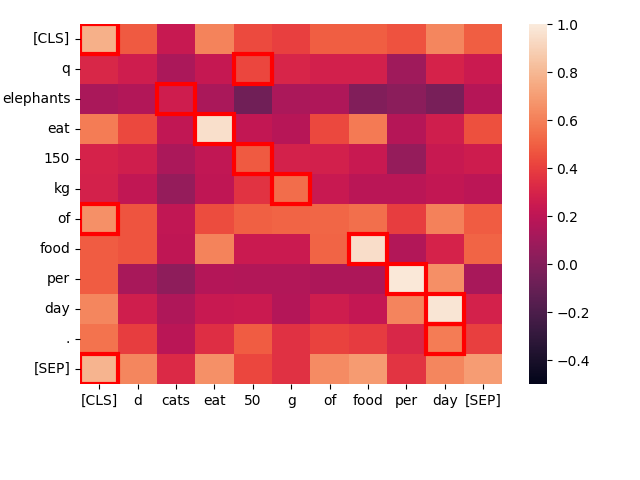

In [5]:
create_heatmap("Elephants eat 150 kg of food per day.", "Cats eat 50 g of food per day.")

And these two:

* "Elephants eat 150 kg of food per day."
* "Employees eat at the company canteen."

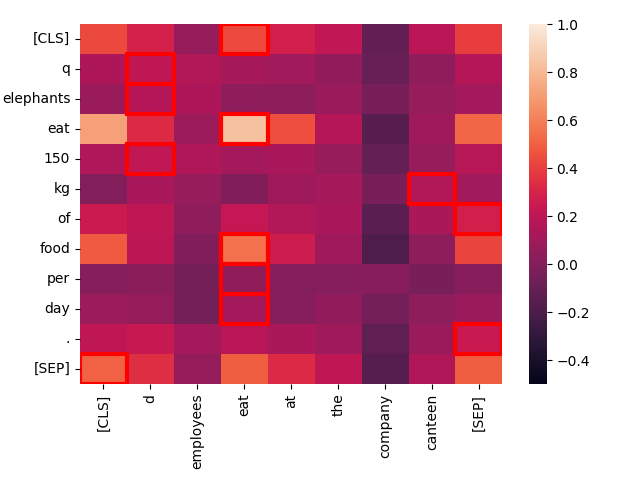

In [6]:
create_heatmap("Elephants eat 150 kg of food per day.", "Employees eat at the company canteen.")

Next, let's try two texts that are similar in meaning but have different syntactic structures:

* "Elephants eat 150 kg of food per day."
* "Every day, the average elephant consumes roughly 150 kg of food."

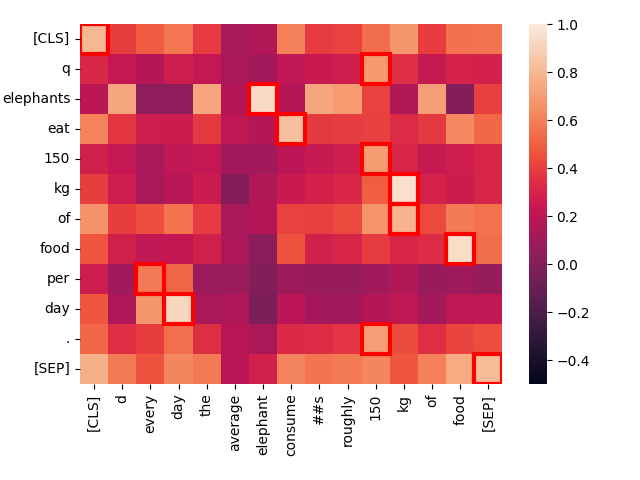

In [4]:
create_heatmap("Elephants eat 150 kg of food per day.", "Every day, the average elephant consumes roughly 150 kg of food.")

Now let's try two completely unrelated texts:

* "Elephants eat 150 kg of food per day."
* "The rain in Spain falls mainly on the plain."

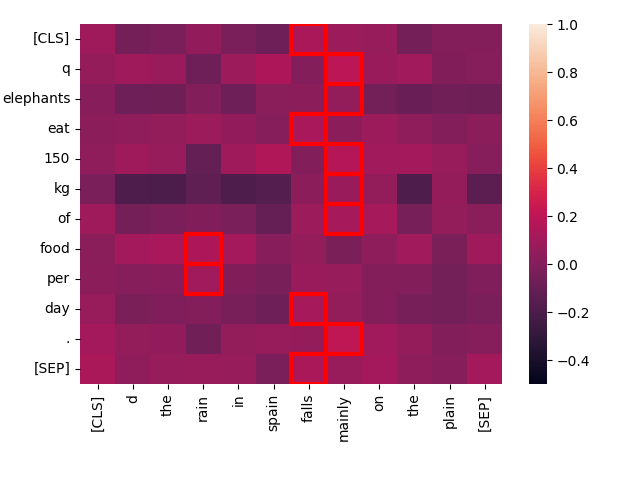

In [7]:
create_heatmap("Elephants eat 150 kg of food per day.", "The rain in Spain falls mainly on the plain.")

### Long Texts

Here, we'll compare a short query text to a long document one. This is more realistic in a RAG system or an information retrieval model. We'll use a text taken from the [Wikipedia page for "Indian Elephant."](https://en.wikipedia.org/wiki/Indian_elephant)

In [8]:
wikipedia_elephants = """
The Indian elephant (Elephas maximus indicus) is one of three extant recognized subspecies of the Asian elephant,
native to mainland Asia. The species is smaller than the African elephant species with a convex back and the
highest body point on its head. The species exhibits significant sexual dimorphism with a male reaching an average
shoulder height of about 3.2 m (10 ft) and weighing up to 5,400 kg (11,900 lb) whereas a female reaches an average
shoulder height of about 2.54 m (8.3 ft) and weighs up to 4,160 kg (9,170 lb). It has a broader skull with a
concave forehead, two large laterally folded ears and a large trunk. It has grey colored smooth skin with four
large legs and a long tail.

The Indian elephant is native to mainland Asia with nearly three-fourth of the population found in India. The species
is also found in other countries of the Indian subcontinent including Nepal, Bangladesh, Bhutan, Myanmar and South
East Asian countries including Thailand, Malaysia, Laos, Cambodia, and Vietnam with small populations in China. It
inhabits grasslands, dry deciduous, moist deciduous, evergreen and semi-evergreen forests across the range. The
species is classified as a megaherbivore and consume up to 150 kg (330 lb) of plant matter per day. They consume a
variety of diet depending on the habitat and seasons and might include leaves and twigs of fresh foliage, thorn
bearing shoots, flowering plants, fruits and grass.

Since 1986, the Asian elephant has been listed as Endangered on the IUCN Red List as the wild population has declined
by at least 50% over the last three elephant generations. The species is threatened by environmental degradation,
habitat loss and fragmentation. Poaching of elephants for ivory is a serious threat in some parts of Asia. Project
Elephant was launched in 1992 by the Government of India to protect elephant habitats and population.

The Indian elephant is a cultural symbol throughout its range and appears in various religious traditions and
mythologies. The elephants are treated positively and is revered as a form of Lord Ganesha in Hinduism. It has been
designated the national heritage animal in India and is the national animal of Thailand and Laos.
"""

We add the `figsize=(50,7)` argument to `create_heatmap` so that the display is more readable.

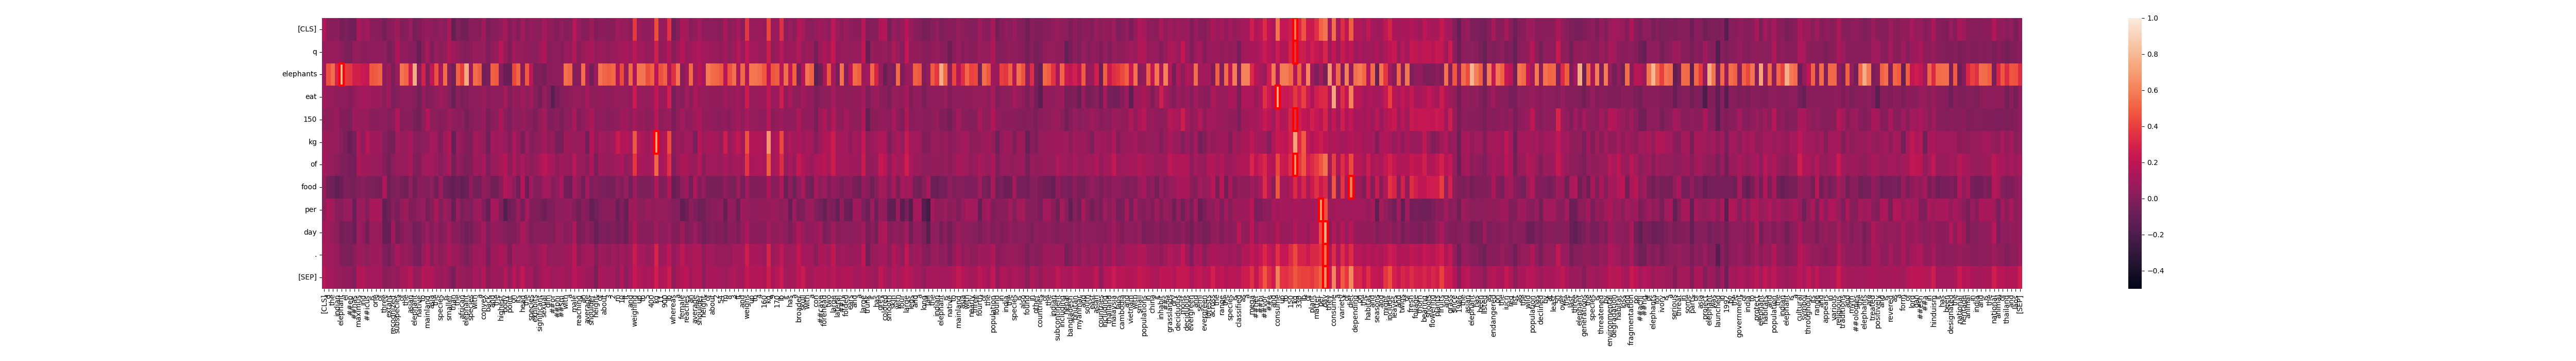

In [15]:
create_heatmap("Elephants eat 150 kg of food per day.", wikipedia_elephants, figsize=(50,7))

And here, we just use the sentence we can see has the most "heat" in the heat map above.

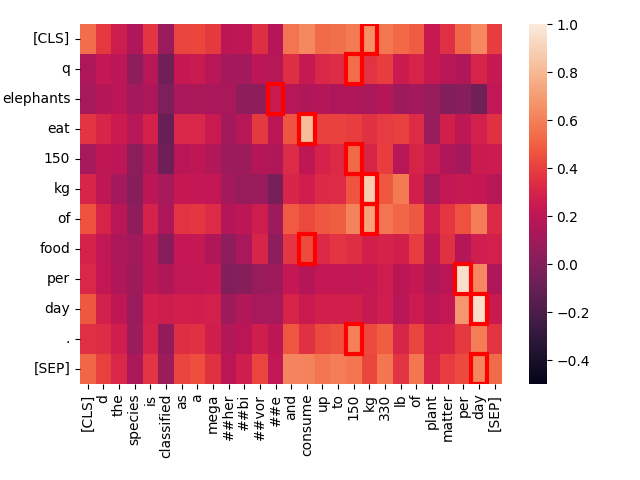

In [10]:
create_heatmap("Elephants eat 150 kg of food per day.", "The species is classified as a megaherbivore and consume up to 150 kg (330 lb) of plant matter per day.")